<h1>Homework 2</h1>
<h3>Natalie Lebedeva, nl1115, no other group members</h3>

For the classification problem below, I chose to follow the SimpleNet architechture (https://arxiv.org/pdf/1608.06037.pdf), although with some modifications. 

Some modifications that I introduced were:
– using crelu instead of relu
– using L2 regularization
– adding a fully connected layer before softmax

I hard-coded some test set labels (the first 50 test pics) so that I could see how the model performs on a tiny subset of test data right away.

The network took too long to train, and the best accuracy I got on dummy test set was 92% while getting 100% on validation and train sets.
While fine-tuning the network, I was primarily changing L2 value, learning rate, and data augmentation techniques.

The augmented dataset size is 180000 because I randomly changed saturation, brightness, and contrast on the entire set and flipped the result left to right.

Unfortunately, I had no time to figure out the tensorboard, and although I added the necessary summary functions, I ran out of time and couldn't train the network again to obtain the tensorboard metrics.



In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import glob
import scipy.misc
import sys
import pickle
import time
from datetime import timedelta
import math
import os
from sklearn.utils import shuffle
from PIL import Image
from PIL import ImageEnhance

%matplotlib inline

In [2]:
tf.logging.set_verbosity(tf.logging.INFO)

In [3]:
tf.__version__

'1.3.0'

In [4]:
a = tf.constant(0.05, shape=[5])

# a = tf.Print(a, [a], message="This is a: ")

In [6]:
class Dataset:
    
    def __init__(self, 
                 train_dir = '', 
                 test_dir = '', 
                 labels_dir = '', 
                 pickle_exists = False,
                 validation_ratio = 0.3):
        
        self.X_train = []
        self.y_train = []
        self.X_test = []
        self.X_train_n = []
        self.X_test_n = []
        self.X_val = []
        self.y_val = []
        self.X_test = []
        self.X_val_n = []
        self.X_val_n = []
        self.dataset_size = 0
        self.validation_ratio = validation_ratio
        self.unrolled_size = 32*32*3
        
        if pickle_exists:
            self.X_train = pickle.load(open("../X_train.p", "rb" ))
            self.y_train = pickle.load(open("../y_train.p", "rb" ))
            self.X_val = pickle.load(open("../X_val.p", "rb" ))
            self.y_val = pickle.load(open("../y_val.p", "rb" ))
            self.X_test = pickle.load(open("../X_test.p", "rb" ))

#             self.X_train = pickle.load(open("X_train_a.p", "rb" ))
#             self.y_train = pickle.load(open("y_train_a.p", "rb" ))
#             self.X_val = pickle.load(open("X_val_a.p", "rb" ))
#             self.y_val = pickle.load(open("y_val_a.p", "rb" ))
#             self.X_test = pickle.load(open("X_test_a.p", "rb" ))
            print("Loading training and test datasets... ")
#             self.X_train = pickle.load(open("X_train_a2.p", "rb" ))
#             self.y_train = pickle.load(open("y_train_a2.p", "rb" ))
#             self.X_val = pickle.load(open("X_val_a2.p", "rb" ))
#             self.y_val = pickle.load(open("y_val_a2.p", "rb" ))
#             self.X_test = pickle.load(open("X_test_a2.p", "rb" ))
            print("Done!")
            
        else:
            
            self.X_train, self.y_train = self.get_train_data(train_dir, labels_dir)
            self.X_test = self.get_images(test_dir)
            
            self.dataset_size = np.shape(self.X_train)[1]
            
            self.change_hue()
            self.dataset_size = np.shape(self.X_train)[1]
#             self.change_satur()
#             self.change_bright()
#             self.change_contr()
            self.flip()
            self.dataset_size = np.shape(self.X_train)[1]
            self.X_train, self.y_train, self.X_val, self.y_val = self.createDataset()
            print("Saving dataset... ")
            print("Shapes: \nTrain X {0} y {1} \nValidation X {2} y {3}".format(self.X_train.shape, 
                                                                                self.y_train.shape,
                                                                                self.X_val.shape,
                                                                                self.y_val.shape))
            pickle.dump(self.X_train, open("X_train_a2.p", "wb" ))
            pickle.dump(self.y_train, open("y_train_a2.p", "wb" ))
            pickle.dump(self.X_train, open("X_val_a2.p", "wb" ))
            pickle.dump(self.y_train, open("y_val_a2.p", "wb" ))
            pickle.dump(self.X_test, open("X_test_a2.p", "wb" ))
#             pickle.dump(self.X_train, open("X_train.p", "wb" ))
#             pickle.dump(self.y_train, open("y_train.p", "wb" ))
#             pickle.dump(self.X_train, open("X_val.p", "wb" ))
#             pickle.dump(self.y_train, open("y_val.p", "wb" ))
#             pickle.dump(self.X_test, open("X_test.p", "wb" ))
            print("Done!")
        
        self.dataset_size = np.shape(self.X_train)[1]
        
        
        
        xstd = np.std(self.X_train)
        xmean = np.mean(self.X_train)
        self.X_train_n = (self.X_train - xmean) / xstd
        self.X_test_n = (self.X_train - xmean) / xstd
        self.X_val_n = (self.X_val - xmean) / xstd
        

        
    # Helper functions, DO NOT modify this
    def createDataset(self):
        
        self.X_train, self.y_train = self.shuffle_data(self.X_train, self.y_train)

        #Split data
        split_index = int(self.dataset_size*(1.0 - self.validation_ratio))
        print("split index", split_index)
        train_X = self.X_train[:, :split_index]
        train_y = self.y_train[ :split_index]
        validation_X = self.X_train[:, split_index:]
        validation_y = self.y_train[ split_index:]
        
        print("Dataset created!")

        return train_X, train_y, validation_X, validation_y
    
    def get_img_array(self, path):
        """
        Given path of image, returns it's numpy array
        """
        return scipy.misc.imread(path)

    def get_label(self, filepath, label2id):
        """
        Files are assumed to be labeled as: /path/to/file/999_frog.png
        Returns label for a filepath
        """
        tokens = filepath.split('/')
        label = tokens[-1].split('_')[1][:-4]
        if label in label2id:
            return label2id[label]
        else:
            sys.exit("Invalid label: " + label)

    def get_labels(self, folder, label2id):
        """
        Returns vector of labels extracted from filenames of all files in folder
        :param folder: path to data folder
        :param label2id: mapping of text labels to numeric ids. (Eg: automobile -> 0)
        """
        files = self.get_files(folder)
        y = []
        for f in files:
            y.append(self.get_label(f,label2id))
        return np.array(y)

    def get_files(self, folder):
        """
        Given path to folder, returns list of files in it
        """
        if folder.split('/')[-1] == 'test':
            filenames = ["" for i in range(5000)]
            for filename in os.listdir(folder):
                if filename[0] != '.':
                    index = int(filename.split('.')[0]) - 1
                    filenames[index] = folder + '/' + filename
            return filenames
        filenames = [file for file in glob.glob(folder+'*/*')]
        filenames.sort()
        return filenames

    def get_label_mapping(self, label_file):
        """
        Returns mappings of label to index and index to label
        The input file has list of labels, each on a separate line.
        """
        with open(label_file, 'r') as f:
            id2label = f.readlines()
            id2label = [l.strip() for l in id2label]
        label2id = {}
        count = 0
        for label in id2label:
            label2id[label] = count
            count += 1
        return id2label, label2id

    def get_images(self, folder):
        """
        returns numpy array of all samples in folder
        each column is a sample resized to 30x30 and flattened
        """
        files = self.get_files(folder)
        images = []
        count = 0

        for f in files:
            count += 1
            if count % 10000 == 0:
                print("Loaded {}/{}".format(count,len(files)))
            img_arr = self.get_img_array(f)
            img_arr = img_arr.flatten() / 255.0
            images.append(img_arr)
        X = np.column_stack(images)

        return X

    def get_train_data(self, train_data_path, labels_path):
        """
        Return X and y
        """
        id2label, label2id = self.get_label_mapping(labels_path + 'labels.txt')
        print(label2id)
        X = self.get_images(train_data_path)
        y = self.get_labels(train_data_path, label2id)
        return X, y   

    
    def get_batch(self, batch_size, start_point, shuffle = False):
        if shuffle:
            self.X_train_n, self.y_train = self.shuffle_data(self.X_train_n, self.y_train)
        X_batch = []
        y_batch = []
        if (start_point + batch_size < self.dataset_size):
            X_batch = self.X_train_n[:, start_point : start_point + batch_size]
            y_batch = self.y_train[start_point : start_point + batch_size]
        else:
            X_batch = self.X_train_n[:, start_point : ]
            y_batch = self.y_train[start_point : ]
            
        return X_batch, y_batch
    
    def change_hue(self):

        X_h = []
        images = []
        for i in range(self.dataset_size):
            
            image = self.X_train[:, i].reshape(32,32,3)
            image = Image.fromarray(np.uint8(image*255))
            color = ImageEnhance.Color(image)
            c_rand = np.random.uniform(0.0, 0.5)
            image = color.enhance(c_rand)
            image = np.array(image)
            img_arr = np.reshape(image, self.unrolled_size) / 255.0
            images.append(img_arr)
            self.y_train=np.append(self.y_train, self.y_train[i])
            
        X_h = np.column_stack(images)
        print(self.X_train.shape, X_h.shape)
        self.X_train = np.hstack((self.X_train, X_h))
        print("+hue data size x = {0}, y = {1}".format(self.X_train.shape, self.y_train.shape))
        
    def flip(self):
        
        X_h = []
        images = []
        for i in range(self.dataset_size):
            
            image = self.X_train[:, i].reshape(32,32,3)
            image = np.fliplr(image)
            img_arr = image.reshape([self.unrolled_size])
            images.append(img_arr)
            self.y_train=np.append(self.y_train, self.y_train[i])
        
        X_h = np.column_stack(images)
        print(self.X_train.shape, X_h.shape)
        self.X_train = np.hstack((self.X_train, X_h))
        print("+flip data size x = {0}, y = {1}".format(self.X_train.shape, self.y_train.shape))
        
       

    def shuffle_data(self, X, y):
        X = np.array(X)
        X, y = shuffle(X.T, y, random_state=None)
        return X.T, y


In [8]:
ds = Dataset('./HW2_data/train',
            './HW2_data/test',
            './HW2_data/', pickle_exists = False)

{'dog': 5, 'cat': 3, 'frog': 6, 'deer': 4, 'ship': 8, 'airplane': 0, 'truck': 9, 'bird': 2, 'automobile': 1, 'horse': 7}
Loaded 10000/45000
Loaded 20000/45000
Loaded 30000/45000
Loaded 40000/45000
(3072, 45000) (3072, 45000)
+hue data size x = (3072, 90000), y = (90000,)
(3072, 90000) (3072, 90000)
+flip data size x = (3072, 180000), y = (180000,)
split index 125999
Dataset created!
Saving dataset... 
Shapes: 
Train X (3072, 125999) y (125999,) 
Validation X (3072, 54001) y (54001,)
Done!


(3072, 125999)


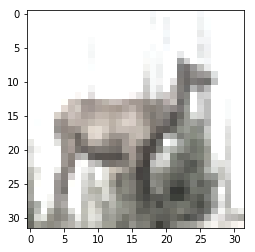

In [9]:
print(ds.X_train_n.shape)
plt.imshow(ds.X_train[:, 1].reshape(32,32,3))
# a = np.fliplr(ds.X_train[:, 1].reshape(32,32,3))
# print(imgs.shape))
# plt.imshow(a)

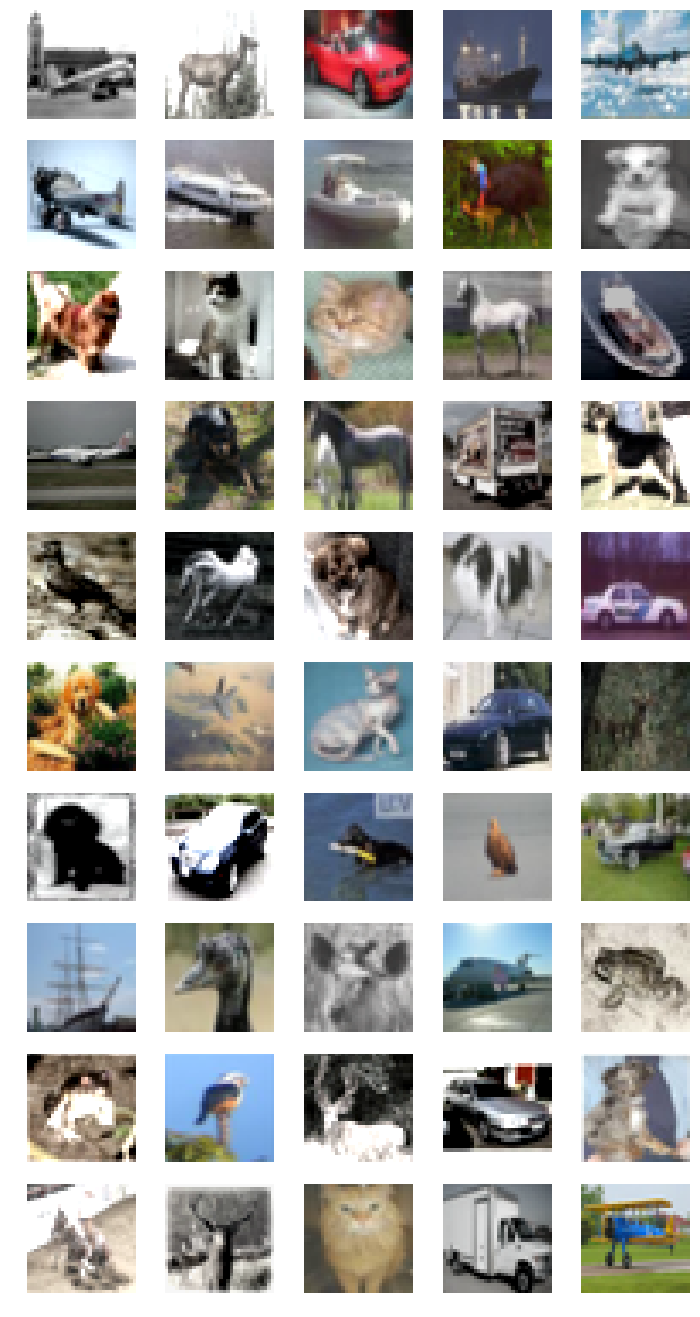

In [11]:
n = 50
# print(X_train[:, :n].shape)
imgs = ds.X_train[:, :n].reshape(32,32,3,-1)
# print(imgs.shape)
plt.figure(figsize=(12,2.5*n/5+1))
plt.axis('off')
for i in range(0, imgs.shape[3]):
    img = imgs[:,:,:,i]
#     print(str(i)+":", img.shape)
    plt.subplot(n/5+1, 5, i+1)
    plt.axis('off')
    plt.imshow(img)

In [12]:
'''classes = {0: 'airplane',
           1: 'automobile', 
           2: 'bird',
           3: 'cat', 
           4: 'deer', 
           5: 'dog', 
           6: 'frog', 
           7: 'horse', 
           8: 'ship', 
           9: 'truck'}'''





"classes = {0: 'airplane',\n           1: 'automobile', \n           2: 'bird',\n           3: 'cat', \n           4: 'deer', \n           5: 'dog', \n           6: 'frog', \n           7: 'horse', \n           8: 'ship', \n           9: 'truck'}"

In [14]:

img_size = 32

num_channels = 3

num_classes = 10

img_size_flat = img_size * img_size * num_channels

In [15]:

x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

y_true_cls = tf.argmax(y_true, axis=1)

In [16]:
# CNN parameters

# Convolutional Layer 1.
filter_size1 = 3          
num_filters1 = 64         

# Convolutional Layer 2.
filter_size2 = 3         
num_filters2 = 128         

# Convolutional Layer 3.
filter_size3 = 3          
num_filters3 = 128         

# Convolutional Layer 4.
filter_size4 = 3          
num_filters4 = 128         

# Convolutional Layer 5.
filter_size5 = 3          
num_filters5 = 128         

# Convolutional Layer 6.
filter_size6 = 3          
num_filters6 = 128         

# Convolutional Layer 7.
filter_size7 = 3          
# num_filters7 = 128 
num_filters7 = 256        

# Convolutional Layer 8.
filter_size8 = 3          
# num_filters8 = 128  
num_filters8 = 256       

# Convolutional Layer 9.
filter_size9 = 3          
# num_filters9 = 128    
num_filters9 = 256     

# Convolutional Layer 10.
filter_size10 = 3          
# num_filters10 = 128    
num_filters10 = 512     

# Convolutional Layer 11.
filter_size11 = 1          
# num_filters11 = 128       
num_filters11 = 2048  

# Convolutional Layer 12.
filter_size12 = 1          
# num_filters12 = 128    
num_filters12 = 256

# Convolutional Layer 13.
filter_size13 = 3          
# num_filters13 = 128   
num_filters13 = 256



# Fully-connected layer.
fc_size = 128             

In [18]:
# layer number: ['conv', num_input_channels, filter_size, num_filters, use_pooling=True, activation='relu']
# layer number: ['flat']
# layer number: ['full' or 'last', num_outputs, use_relu=True]



network_parameters = {'layer_1': ['conv', num_channels, filter_size1, num_filters1, False, 'relu'],
                      'layer_2': ['conv', num_filters1, filter_size2, num_filters2, False, 'relu'],
                      'layer_3': ['conv', num_filters2, filter_size3, num_filters3, False, 'relu'],
                      'layer_4': ['conv', num_filters3, filter_size4, num_filters4, True, 'relu'],
                      'layer_5': ['conv', num_filters4, filter_size5, num_filters5, False, 'relu'],
                      'layer_6': ['conv', num_filters5, filter_size6, num_filters6, False, 'relu'],
                      'layer_7': ['conv', num_filters6, filter_size7, num_filters7, True, 'relu'],
                      'layer_8': ['conv', num_filters7, filter_size8, num_filters8, False, 'relu'],
                      'layer_9': ['conv', num_filters8, filter_size9, num_filters9, True, 'relu'],
                      'layer_10': ['conv', num_filters9, filter_size10, num_filters10, False, 'relu'],
                      'layer_11': ['conv', num_filters10, filter_size11, num_filters11, False, 'relu'],
                      'layer_12': ['conv', num_filters11, filter_size12, num_filters12, True, 'relu'],
                      'layer_13': ['conv', num_filters12, filter_size13, num_filters13, True, 'relu'],
                      'layer_14': ['flat'], 
                      'layer_15': ['full', '', fc_size], 
                      'layer_16': ['last', fc_size, num_classes]}



class CNN:
    
    def __init__(self, input_layer, num_classes, network_parameters, y_true, y_true_cls, 
                 drop_prob=0.0, reg_lambda_L1=0.0, reg_lambda_L2=0.0, training=True):
        self.BATCH_NORM_DECAY = 0.95
        self.BATCH_NORM_EPSILON = 1e-5
        self.training = training
        self.total_layers = len(network_parameters)
        self.num_conv_layers = 0
        self.num_full_layers = 0
        self.regularizer = tf.contrib.layers.l2_regularizer(scale=reg_lambda_L2)
        
        for key in network_parameters:
            if network_parameters[key][0] == 'conv':
                self.num_conv_layers += 1
            elif network_parameters[key][0] == 'full' or network_parameters[key][0] == 'last':
                self.num_full_layers += 1
        
        print("Num conv layers: ", self.num_conv_layers)
        print("Num fully connected layers: ", self.num_full_layers)
        print("Total layers: ", self.total_layers)
        
        layer = ''
        weights = []
        
        self.last_layer = ''
        self.drop_prob = drop_prob
        self.y_pred = ''
        self.y_pred_cls = ''
        
        for i in range(0, self.num_conv_layers):
            print("\n----------", i)
            print("\nLayer_" + str(i+1) + '  ' + network_parameters["layer_" + str(i+1)][0])
            layer_param_list = network_parameters["layer_" + str(i+1)]
            print(layer_param_list)
            if i == 0:
                
                layer, weights = self.conv_layer(input_layer, 
                                            layer_param_list[1], 
                                            layer_param_list[2], 
                                            layer_param_list[3], 
                                            use_pooling=layer_param_list[4],
                                            activation=layer_param_list[5],
                                                name='layer_'+str(i+1))
                
            else:
                
                layer, weights = self.conv_layer(layer, 
                                            layer_param_list[1], 
                                            layer_param_list[2], 
                                            layer_param_list[3], 
                                            use_pooling=layer_param_list[4],
                                            activation=layer_param_list[5],
                                                name='layer_'+str(i+1))
            
            
            
        layer, num_features = self.flatten_layer(layer) # flatten
            
            
            
        for i in range(self.num_conv_layers + 2, self.total_layers + 1):
            print("\nLayer_" + str(i) + '  ' + network_parameters["layer_" + str(i)][0])

            layer_param_list = network_parameters["layer_" + str(i)]
            print(layer_param_list)
            if i == (self.num_conv_layers + 2):

                layer, num_features = self.fully_connected_layer(layer, 
                                                        num_features,
                                                        layer_param_list[2])
                
                
            elif layer_param_list[0] == 'full':

                layer, num_features = self.fully_connected_layer(layer,
                                                                 layer_param_list[1],
                                                                 layer_param_list[2])

            elif layer_param_list[0] == 'last':
                # + softmax
                layer, num_features = self.fully_connected_layer(layer,
                                                                 layer_param_list[1],
                                                                 layer_param_list[2])
                self.last_layer = layer
                self.y_pred = tf.nn.softmax(layer)
                self.y_pred_cls = tf.argmax(self.y_pred, axis=1)
    
    
      

    def conv_layer(self, prev_layer,              
                   num_input_channels, 
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True,
                   activation='relu',
                  name=''):  

        # Shape of the filter-weights for the convolution.
        
        shape = [filter_size, filter_size, num_input_channels, num_filters]

       
        weights = tf.Variable(tf.truncated_normal(shape, stddev=0.05))

        initializer = tf.contrib.layers.xavier_initializer_conv2d()
        biases = tf.Variable(tf.constant(0.05, shape=[num_filters]))
        
        layer = tf.layers.conv2d(prev_layer,
                                filters= num_filters,
                                kernel_size= filter_size,
                                strides=(1, 1),
                                padding='SAME',
                                name='conv_'+name,
                                data_format='channels_last',
                                dilation_rate=(1, 1),
                                activation=None,
                                use_bias=True,
                                kernel_initializer=initializer,
                                bias_initializer=tf.zeros_initializer(),
                                kernel_regularizer=self.regularizer)

        # Add the biases to the results of the convolution.
        layer += biases
        
        if use_pooling:
            layer = tf.layers.max_pooling2d(layer,
                                    (2,2),
                                    (2,2),
                                    padding='SAME',
                                    data_format='channels_last',
                                    name='pool'+name)

            
        layer =  tf.contrib.layers.batch_norm(inputs=layer,
                                            decay=self.BATCH_NORM_DECAY,
                                            center=True,
                                            scale=True,
                                            epsilon=self.BATCH_NORM_EPSILON,
                                            activation_fn=None,
                                            param_initializers=None,
                                            param_regularizers=None,
                                            updates_collections=tf.GraphKeys.UPDATE_OPS,
                                            is_training=self.training,
                                            reuse=None,
                                            variables_collections=None,
                                            outputs_collections=None,
                                            trainable=True,
                                            batch_weights=None,
                                            fused=True)
        
        layer = tf.nn.elu(layer)
        
#         if self.drop_prob > 0:
#             layer = tf.nn.dropout(layer, self.drop_prob)

        print(layer)
        hist_name = "conv_" + name + "_weights"
        tf.summary.histogram(hist_name, weights)
        return layer, weights
    
    
    def fully_connected_layer(self, prev_layer,         
                 num_inputs,    
                 num_outputs,   
                 use_relu=True):

       
        shape=[num_inputs, num_outputs]
        weights = tf.Variable(tf.truncated_normal([num_inputs, num_outputs], stddev=0.05))
        biases = tf.Variable(tf.constant(0.05, shape=[num_outputs]))

       
        layer = tf.matmul(prev_layer, weights) + biases

        if use_relu:
            layer = tf.nn.relu(layer)
            
#         if self.drop_prob > 0:
#             layer = tf.nn.dropout(layer, self.drop_prob)

        print(layer)
        hist_name = "fully_connected_weights"
        tf.summary.histogram(hist_name, weights)
        return layer, num_outputs
    

    def flatten_layer(self, layer):
   
        layer_shape = layer.get_shape()

        num_features = layer_shape[1:4].num_elements()

        layer_flat = tf.reshape(layer, [-1, num_features])

        print(layer_flat)
        return layer_flat, num_features  

In [20]:
# 0.00005

network = CNN(x_image, num_classes, 
              network_parameters, y_true, y_true_cls, 0.5, reg_lambda_L2=0.0005)

Num conv layers:  13
Num fully connected layers:  2
Total layers:  16

---------- 0

Layer_1  conv
['conv', 3, 3, 64, False, 'relu']
Tensor("CRelu/Relu:0", shape=(?, 32, 32, 128), dtype=float32)

---------- 1

Layer_2  conv
['conv', 64, 3, 128, False, 'relu']
Tensor("CRelu_1/Relu:0", shape=(?, 32, 32, 256), dtype=float32)

---------- 2

Layer_3  conv
['conv', 128, 3, 128, False, 'relu']
Tensor("CRelu_2/Relu:0", shape=(?, 32, 32, 256), dtype=float32)

---------- 3

Layer_4  conv
['conv', 128, 3, 128, True, 'relu']
Tensor("CRelu_3/Relu:0", shape=(?, 16, 16, 256), dtype=float32)

---------- 4

Layer_5  conv
['conv', 128, 3, 128, False, 'relu']
Tensor("CRelu_4/Relu:0", shape=(?, 16, 16, 256), dtype=float32)

---------- 5

Layer_6  conv
['conv', 128, 3, 128, False, 'relu']
Tensor("CRelu_5/Relu:0", shape=(?, 16, 16, 256), dtype=float32)

---------- 6

Layer_7  conv
['conv', 128, 3, 256, True, 'relu']
Tensor("CRelu_6/Relu:0", shape=(?, 8, 8, 512), dtype=float32)

---------- 7

Layer_8  conv
[

In [21]:
ROOT_DIR = os.getcwd()
LOG_DIR = os.path.join(ROOT_DIR, "logs_t")
print("Saving Tensorflow model logs to : \n{0}\n\n".format(LOG_DIR))


cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=network.last_layer,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)
tf.summary.scalar('training_loss', cost)

optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)

correct_prediction = tf.equal(network.y_pred_cls, y_true_cls)

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
training_summary = tf.summary.scalar("training_accuracy", accuracy)

merged = tf.summary.merge_all()



In [22]:
session = tf.Session()
session.run(tf.global_variables_initializer())
train_batch_size = 512

writer = tf.summary.FileWriter(LOG_DIR, graph=session.graph)

In [23]:
def one_hot(y, num_classes=10):

    """

    Converts each label index in y to vector with one_hot encoding

    """

    y_one_hot = np.zeros((num_classes, y.shape[0]))

    y_one_hot[y, range(y.shape[0])] = 1

    return y_one_hot

In [28]:
labels_t = np.array([7,1,4,1,0,2,2,5,9,6,0,1,3,1,1,2,1,8,5,6,1,2,4,2,8,8,3,7,1,7,1,7,5,1,7,0,7,8,3,6,1,2,2,5,9,8,4,8,9,4])
len(labels_t)

classes = {0: 'airplane',
           1: 'automobile', 
           2: 'bird',
           3: 'cat', 
           4: 'deer', 
           5: 'dog', 
           6: 'frog', 
           7: 'horse', 
           8: 'ship', 
           9: 'truck'}

In [29]:
feed_dict_train = {}    

def train(epochs):
    done = False
    
    num_batches = ds.dataset_size // train_batch_size + 1
    
    for e in range(epochs):
        if done:
            break
        print("Epoch {}...".format(e+1))
        
        for i in range(num_batches):
            if i == 0:
                x_batch, y_true_batch = ds.get_batch(train_batch_size, i*train_batch_size, shuffle=True)
            x_batch, y_true_batch = ds.get_batch(train_batch_size, i*train_batch_size, shuffle=False)
            
            
            feed_dict_train = {x: x_batch.T,
                               y_true: one_hot(y_true_batch).T}

            
            
            session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every n epochs.
        if e % 1 == 0:
            
            # get validation accuracy
            
            acc, train_summ = session.run([accuracy, merged], 
                                          feed_dict=feed_dict_train)
            
            writer.add_summary(train_summ, e)
            
            
            msg = "Traning Epoch: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(e + 1, acc))
            

    
            
            num_test = 1024

            cls_pred = np.zeros(shape=num_test, dtype=np.int)

            images, labels = ds.shuffle_data(ds.X_val_n, ds.y_val)
            images = images[:,:num_test]
            labels = labels[:num_test]
            feed_dict2 = {x: images.T,
                         y_true: one_hot(labels).T}

            cls_pred = session.run(network.y_pred_cls, feed_dict=feed_dict2)

            correct = (labels == cls_pred)

            correct_sum = correct.sum()

            val_acc = float(correct_sum) / num_test

            msg = "Accuracy on Validation-Set: {0:.1%} ({1} / {2})"
            print(msg.format(val_acc, correct_sum, num_test))
            
            # get test accuracy
            
            num_test = 50

            cls_pred = np.zeros(shape=num_test, dtype=np.int)


            images = ds.X_test[:,:num_test]


            feed_dict = {x: images.T,
                         y_true: one_hot(labels_t).T}

                
            cls_pred = session.run(network.y_pred_cls, feed_dict=feed_dict)

            correct = (labels_t == cls_pred)
            correct_sum = correct.sum()


            acc = float(correct_sum) / num_test

            msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
            print(msg.format(acc, correct_sum, num_test))
#             if acc >= 0.98:
#                 print("donezo")
#                 done = True
#                 break
            
            

In [30]:
# Train the Model for some Epochs
epochs = 41

train(epochs)

Epoch 1...
Traning Epoch:      1, Training Accuracy:  87.2%
Accuracy on Validation-Set: 67.3% (689 / 1024)
Accuracy on Test-Set: 78.0% (39 / 50)
Epoch 2...
Traning Epoch:      2, Training Accuracy:  89.4%
Accuracy on Validation-Set: 76.3% (781 / 1024)
Accuracy on Test-Set: 80.0% (40 / 50)
Epoch 3...
Traning Epoch:      3, Training Accuracy:  89.4%
Accuracy on Validation-Set: 80.1% (820 / 1024)
Accuracy on Test-Set: 82.0% (41 / 50)
Epoch 4...
Traning Epoch:      4, Training Accuracy: 100.0%
Accuracy on Validation-Set: 88.6% (907 / 1024)
Accuracy on Test-Set: 86.0% (43 / 50)
Epoch 5...
Traning Epoch:      5, Training Accuracy: 100.0%
Accuracy on Validation-Set: 90.7% (929 / 1024)
Accuracy on Test-Set: 84.0% (42 / 50)
Epoch 6...
Traning Epoch:      6, Training Accuracy: 100.0%
Accuracy on Validation-Set: 90.1% (923 / 1024)
Accuracy on Test-Set: 86.0% (43 / 50)
Epoch 7...
Traning Epoch:      7, Training Accuracy: 100.0%
Accuracy on Validation-Set: 91.6% (938 / 1024)
Accuracy on Test-Set: 8

KeyboardInterrupt: 

In [32]:
classes = {0: 'airplane',
           1: 'automobile', 
           2: 'bird',
           3: 'cat', 
           4: 'deer', 
           5: 'dog', 
           6: 'frog', 
           7: 'horse', 
           8: 'ship', 
           9: 'truck'}

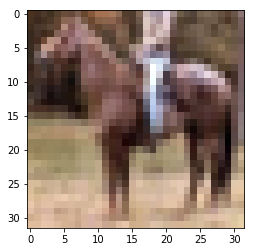

In [33]:
# print(ds.X_train_n.shape)
plt.imshow(ds.X_test[:, 0].reshape(32,32,3))

In [41]:
num_test = 5
# n = 50
shift = 2780
   
cls_pred = np.zeros(shape=num_test, dtype=np.int)

images = ds.X_test[:,shift:num_test+shift]

feed_dict = {x: images.T}

cls_pred = session.run(network.y_pred_cls, feed_dict=feed_dict)
res = list(cls_pred)
print(res)
for i in range(len(res)):
    res[i] = classes[res[i]]

print(res)

print(cls_pred)

[0, 5, 9, 5, 8]
['airplane', 'dog', 'truck', 'dog', 'ship']
[0 5 9 5 8]


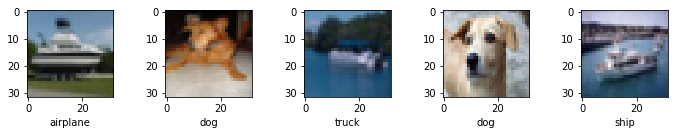

In [42]:
n = 5
# shift = 200
# print(X_train[:, :n].shape)
imgs = ds.X_test[:, shift:shift+n].reshape(32,32,3,-1)
# print(imgs.shape)
plt.figure(figsize=(12,2.5*n/5+1))
plt.axis('off')
for i in range(0, imgs.shape[3]):
    img = imgs[:,:,:,i]
#     print(str(i)+":", img.shape)
    plt.subplot(n/5+1, 5, i+1)
#     plt.axis('off')
    plt.xlabel(res[i])
    plt.imshow(img)

In [49]:
num_test = 1000
# n = 50
# shift = 500
res = []
for i in range(5):
    
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    images = ds.X_test[:,i*num_test:num_test*(i+1)]

    feed_dict = {x: images.T}

    cls_pred = session.run(network.y_pred_cls, feed_dict=feed_dict)
    res += (list(cls_pred))
print(len(res))
    
for i in range(len(res)):
    res[i] = classes[res[i]]


    
print(len(res))

# print(cls_pred)

5000
5000


In [50]:
import pandas as pd
ids = np.array([[i for i in range(5000)]])
# print(np.array([res]).T)
df_arr = np.hstack((ids.T, np.array([res]).T))
# print(df_arr.shape)
df = pd.DataFrame(df_arr, columns=['id','label'])


In [51]:
df.head(20)

,id,label
0,0,horse
1,1,automobile
2,2,deer
3,3,automobile
4,4,airplane
5,5,bird
6,6,bird
7,7,dog
8,8,truck
9,9,frog


In [52]:
file_name = 'test_submission_2328feb25_aug.csv'
df.to_csv(file_name, sep=',', index=False)

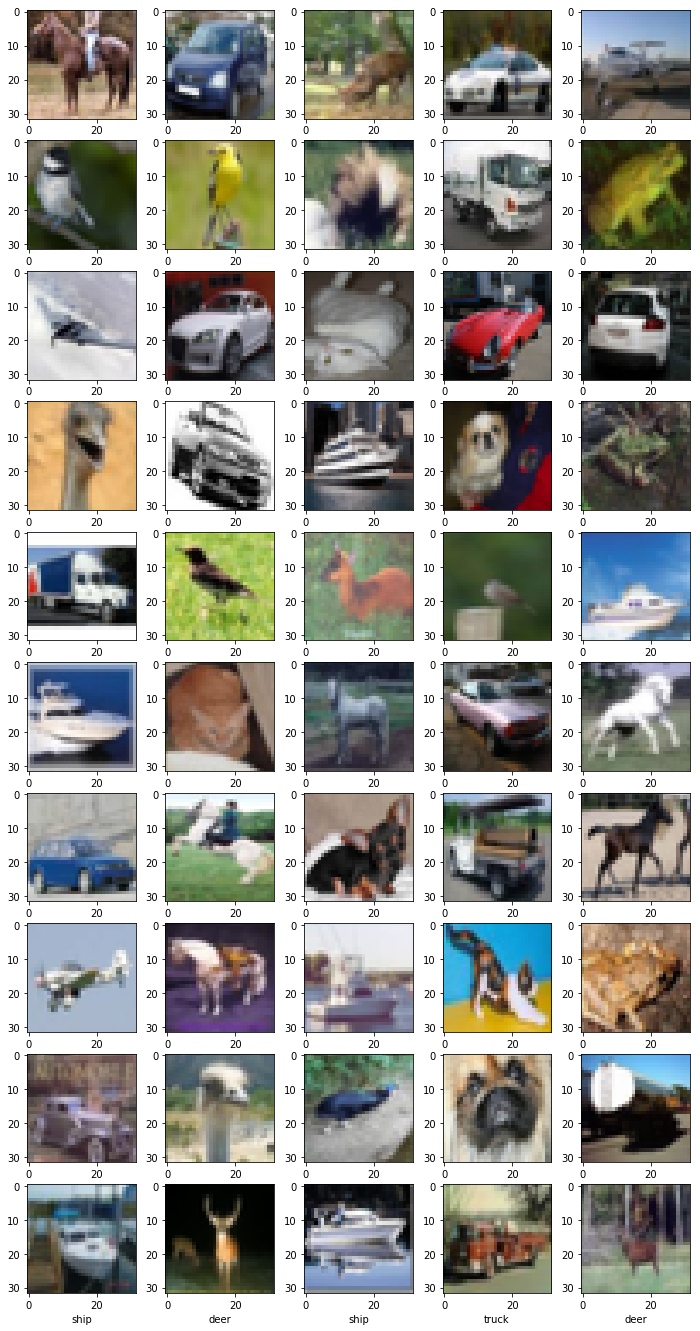

In [53]:
n = 50
shift = 0
# print(X_train[:, :n].shape)
imgs = ds.X_test[:, shift:shift+n].reshape(32,32,3,-1)
# print(imgs.shape)
plt.figure(figsize=(12,2.5*n/5+1))
plt.axis('off')
for i in range(0, imgs.shape[3]):
    img = imgs[:,:,:,i]
#     print(str(i)+":", img.shape)
    plt.subplot(n/5+1, 5, i+1)
#     plt.axis('off')
    plt.xlabel(res[i])
    plt.imshow(img)

In [56]:
num_test = 1000
# n = 50
# shift = 500
res = []
for i in range(5):
    
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    images = ds.X_test[:,i*num_test:num_test*(i+1)]

    feed_dict = {x: images.T}

    cls_pred = session.run(network.y_pred_cls, feed_dict=feed_dict)
    res += (list(cls_pred))
print(len(res))
np.save('ans-nl1115', res) 
for i in range(len(res)):
    res[i] = classes[res[i]]


    
print(len(res))

# print(cls_pred)

5000
5000


In [55]:
df = pd.DataFrame(np.array([res]).T, columns=['label'])
df.head(50)

,label
0,horse
1,automobile
2,deer
3,automobile
4,airplane
5,bird
6,bird
7,dog
8,truck
9,frog
